# Import libraries 

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.fft import fft, fftfreq

# Utils

In [75]:
def plot_histogram(series, bins=10, title='Histogram', xlabel='Values', ylabel='Frequency'):
    """
    Plots a histogram from a pandas Series.
    
    Parameters:
    series (pd.Series): The data to plot.
    bins (int): Number of bins in the histogram (default is 10).
    title (str): The title of the histogram (default is 'Histogram').
    xlabel (str): The label for the x-axis (default is 'Values').
    ylabel (str): The label for the y-axis (default is 'Frequency').
    """
    plt.figure(figsize=(10, 6))
    plt.hist(series, bins=bins, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()
    
def scatter_plot_feature(dataframe, feature, num_points=100, title='Scatter Plot', xlabel='Index', ylabel='Value'):
    """
    Creates a scatter plot for a specified feature.
    
    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing the data.
    feature (str): The name of the feature column to plot.
    num_points (int): The number of points to plot (default is 100).
    title (str): The title of the plot (default is 'Scatter Plot').
    xlabel (str): The label for the x-axis (default is 'Index').
    ylabel (str): The label for the y-axis (default is 'Value').
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(range(num_points), dataframe[feature][0:num_points], alpha=0.6)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# Import Mental workload sheet

In [2]:
import os 

os.getcwd()

'C:\\Users\\Mohamed Mellouky\\cerv_internship\\MentalWorkload-PhysiologicalSignals-ML'

In [3]:
nasa_tlx_df = pd.read_excel('./src/notebooks/data/All_Participant_NASATLX.xlsx')

In [4]:
nasa_tlx_df['ID'] = nasa_tlx_df['ID'].str.replace('ID', 'S')
nasa_tlx_df['ESSAI'] = nasa_tlx_df['ESSAI'].str.replace('Essai', 'trial')


In [5]:
session1_nasatlx = nasa_tlx_df[nasa_tlx_df['SESSION'] == 'Session1']

In [6]:
session1_nasatlx.rename(columns={
    'ESSAI' :  'trial', 
    'ID' : 'subject' 
    }, 
    inplace=True)

C:\Users\Mohamed Mellouky\AppData\Local\Temp\ipykernel_8712\1721380851.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session1_nasatlx.rename(columns={


In [7]:
session1_nasatlx.to_csv('./src/notebooks/data/session1_nasatlx_scores.csv', sep=';', index=False)

# Read physiological signals

In [8]:

bvp_df = pd.read_csv("./src/notebooks/data/BVP.csv", sep=';')
acc_df = pd.read_csv("./src/notebooks/data/ACC.csv", sep=';')
temp_df = pd.read_csv("./src/notebooks/data/TEMP.csv", sep=';')
eda_df = pd.read_csv("./src/notebooks/data/EDA.csv", sep=';')

In [9]:
acc_df['magnitude'] = np.sqrt(acc_df['x_axis']**2 + acc_df['y_axis']**2 + acc_df['z_axis']**2)

# Feature Extraction 

In [40]:

def non_overlapping_rolling_stats(data, window_size, signal_name, sampling_rate):
    
    peak_freq_signals = ['EMG', 'BVP']
    slope_signals = ["TEMP"]
    
    mean_vals = []
    std_vals = []
    min_vals = []
    max_vals = []
    trial_lst = []
    peak_freqs = []
    slopes = []
    
    for start in range(0, len(data), window_size):
        window_data = data[start:start + window_size][signal_name]
        print(f'subject_data trial : {data[start:start + window_size].trial.unique()}')
        trial_lst.append(data[start:start + window_size].trial.unique()[0])
        if len(window_data) == window_size:
            mean_vals.append(np.round(window_data.mean(), 2))
            std_vals.append(np.round(window_data.std(), 2))
            min_vals.append(np.round(window_data.min(), 2))
            max_vals.append(np.round(window_data.max(), 2))
            
            if signal_name in peak_freq_signals : 
                # FFT to calculate peak frequency
                yf = fft(window_data.values)
                xf = fftfreq(window_size, 1 / sampling_rate)
                peak_freq = xf[np.argmax(np.abs(yf))]
                peak_freqs.append(peak_freq)
                
            if signal_name in slope_signals : 
                x = np.arange(window_size)
                y = window_data
                p = np.polyfit(x, y, 1)
                slopes.append(p[0])
    
    if signal_name in peak_freq_signals : 
        result = pd.DataFrame({
        f'{signal_name}mean': mean_vals,
        f'{signal_name}std': std_vals,
        f'{signal_name}min': min_vals,
        f'{signal_name}max': max_vals, 
        f'{signal_name}peak_freq': peak_freqs, 
        f'trial' : trial_lst
        })
    elif signal_name in slope_signals : 
        result = pd.DataFrame({
        f'{signal_name}mean': mean_vals,
        f'{signal_name}std': std_vals,
        f'{signal_name}min': min_vals,
        f'{signal_name}max': max_vals, 
        f'{signal_name}slope': slopes, 
        f'trial' : trial_lst
        })
    else : 
        result = pd.DataFrame({
        f'{signal_name}mean': mean_vals,
        f'{signal_name}std': std_vals,
        f'{signal_name}min': min_vals,
        f'{signal_name}max': max_vals, 
        f'trial' : trial_lst
    })
    return result

In [11]:
eda_df[eda_df['subject'] == 'S10'].trial.values

array(['trial1', 'trial1', 'trial1', ..., 'trial5', 'trial5', 'trial5'],
      dtype=object)

In [43]:
def feature_extraction(data, window_size, signal_name, sampling_rate) : 
    subjects_lst = data.subject.unique() 

    temp_subject_lst = []
    temp_feats_lst = []
    for subject in subjects_lst : 
        subject_data = data[data['subject'] == subject]
        features = non_overlapping_rolling_stats(data=subject_data, window_size=window_size, signal_name=signal_name, sampling_rate=sampling_rate)
        temp_feats_lst.append(features)
        for _ in range(0, int(features.shape[0])) : 
            temp_subject_lst.append(subject)


    features = pd.DataFrame()
    for feat_df in temp_feats_lst : 
        features = pd.concat([features, feat_df], axis=0)


    features = features.reset_index()
    features = pd.concat([features, pd.DataFrame(temp_subject_lst)], axis=1)
    # features.columns = ['index', f'{signal_name}mean', f'{signal_name}std', f'{signal_name}min', f'{signal_name}max', 'subject']
    features = features.rename(columns={
        0 : 'subject'
    })
    
    print(f'{signal_name} feature extraction : feature set shape : {features.shape}')
    
    return features


In [22]:
eda_df

,subject,trial,EDA
0,S10,trial1,4.218009
1,S10,trial1,4.216728
2,S10,trial1,4.202634
3,S10,trial1,4.219291
4,S10,trial1,4.235948
...,...,...,...
147667,S9,trial7,0.362884
147668,S9,trial7,0.380822
147669,S9,trial7,0.394917
147670,S9,trial7,0.391073


In [44]:
temp = feature_extraction(eda_df, 4, 'EDA', 4)
temp

subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_data trial : ['trial1']
subject_

,index,EDAmean,EDAstd,EDAmin,EDAmax,trial,subject
0,0,4.21,0.01,4.20,4.22,trial1,S10
1,1,4.25,0.01,4.24,4.25,trial1,S10
2,2,4.24,0.01,4.22,4.25,trial1,S10
3,3,4.23,0.01,4.22,4.24,trial1,S10
4,4,4.21,0.01,4.21,4.22,trial1,S10
...,...,...,...,...,...,...,...
36913,523,0.28,0.00,0.28,0.28,trial7,S9
36914,524,0.28,0.00,0.27,0.28,trial7,S9
36915,525,0.29,0.01,0.28,0.31,trial7,S9
36916,526,0.34,0.02,0.32,0.36,trial7,S9


In [ ]:
sampling_rate = 4
window_size = 4
eda_features = feature_extraction(eda_df, window_size=window_size, signal_name='EDA', sampling_rate=sampling_rate)
temp_features = feature_extraction(temp_df, window_size=window_size, signal_name='TEMP', sampling_rate=sampling_rate)

window_size = 32
x_acc_features = feature_extraction(acc_df, window_size=window_size, signal_name='x_axis',sampling_rate=sampling_rate)
y_acc_features = feature_extraction(acc_df, window_size=window_size, signal_name='y_axis', sampling_rate=sampling_rate)
z_acc_features = feature_extraction(acc_df, window_size=window_size, signal_name='z_axis', sampling_rate=sampling_rate)
magnitude_acc_features = feature_extraction(acc_df, window_size=window_size, signal_name='magnitude', sampling_rate=sampling_rate)

window_size = 64
sampling_rate = 4
bvp_features = feature_extraction(bvp_df, window_size=window_size, signal_name='BVP', sampling_rate=sampling_rate)

In [82]:
features = pd.concat([eda_features, temp_features, x_acc_features, y_acc_features, z_acc_features, magnitude_acc_features, bvp_features], axis=1)
features.drop(labels=['index'], inplace=True, axis=1)

In [84]:
features = features.T.drop_duplicates().T

In [85]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36918 entries, 0 to 36917
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   EDAmean        36918 non-null  object
 1   EDAstd         36918 non-null  object
 2   EDAmin         36918 non-null  object
 3   EDAmax         36918 non-null  object
 4   trial          36918 non-null  object
 5   subject        36918 non-null  object
 6   TEMPmean       36918 non-null  object
 7   TEMPstd        36918 non-null  object
 8   TEMPslope      36918 non-null  object
 9   x_axismean     36918 non-null  object
 10  x_axisstd      36918 non-null  object
 11  x_axismin      36918 non-null  object
 12  x_axismax      36918 non-null  object
 13  y_axismean     36918 non-null  object
 14  y_axisstd      36918 non-null  object
 15  y_axismin      36918 non-null  object
 16  y_axismax      36918 non-null  object
 17  z_axismean     36918 non-null  object
 18  z_axisstd      36918 non-n

In [55]:
features_ = pd.merge(features, session1_nasatlx, on=['subject', 'trial'])
features_

,EDAmean,EDAstd,EDAmin,EDAmax,trial,subject,TEMPmean,TEMPstd,TEMPslope,x_axismean,...,BVPmax,BVPpeak_freq,SESSION,Exigence Mentale,Exigence Physique,Exigence Temporelle,Effort,Performance,Frustration,UNWEIGHTED SUM (R-TLX)
0,4.21,0.01,4.2,4.22,trial1,S10,32.99,0.0,-0.0,35.53,...,148.96,0.0,Session1,19,0,0,16,65,0,16.666667
1,4.25,0.01,4.24,4.25,trial1,S10,33.0,0.0,-0.0,31.16,...,47.23,0.0,Session1,19,0,0,16,65,0,16.666667
2,4.24,0.01,4.22,4.25,trial1,S10,33.03,0.0,0.0,35.0,...,118.71,0.0,Session1,19,0,0,16,65,0,16.666667
3,4.23,0.01,4.22,4.24,trial1,S10,32.99,0.0,-0.0,33.09,...,234.32,0.0625,Session1,19,0,0,16,65,0,16.666667
4,4.21,0.01,4.21,4.22,trial1,S10,33.0,0.0,-0.0,38.91,...,156.8,0.0625,Session1,19,0,0,16,65,0,16.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36913,0.28,0.0,0.28,0.28,trial7,S9,33.49,0.0,-0.0,-18.91,...,82.03,0.125,Session1,12,34,0,21,24,11,17.000000
36914,0.28,0.0,0.27,0.28,trial7,S9,33.49,0.0,-0.0,-14.31,...,114.68,0.125,Session1,12,34,0,21,24,11,17.000000
36915,0.29,0.01,0.28,0.31,trial7,S9,33.49,0.0,-0.0,-9.09,...,103.38,0.1875,Session1,12,34,0,21,24,11,17.000000
36916,0.34,0.02,0.32,0.36,trial7,S9,33.47,0.0,-0.0,-22.66,...,98.08,0.0625,Session1,12,34,0,21,24,11,17.000000


In [81]:
features_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36918 entries, 0 to 36917
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   EDAmean                 36918 non-null  object 
 1   EDAstd                  36918 non-null  object 
 2   EDAmin                  36918 non-null  object 
 3   EDAmax                  36918 non-null  object 
 4   trial                   36918 non-null  object 
 5   subject                 36918 non-null  object 
 6   TEMPmean                36918 non-null  object 
 7   TEMPstd                 36918 non-null  object 
 8   TEMPslope               36918 non-null  object 
 9   x_axismean              36918 non-null  object 
 10  x_axisstd               36918 non-null  object 
 11  x_axismin               36918 non-null  object 
 12  x_axismax               36918 non-null  object 
 13  y_axismean              36918 non-null  object 
 14  y_axisstd               36918 non-null

In [60]:
features_.to_csv('./src/notebooks/data/labeled_features.csv', sep=';', index=False)

# Data Analysis

In [79]:
features_.columns

Index(['EDAmean', 'EDAstd', 'EDAmin', 'EDAmax', 'trial', 'subject', 'TEMPmean',
       'TEMPstd', 'TEMPslope', 'x_axismean', 'x_axisstd', 'x_axismin',
       'x_axismax', 'y_axismean', 'y_axisstd', 'y_axismin', 'y_axismax',
       'z_axismean', 'z_axisstd', 'z_axismin', 'z_axismax', 'magnitudemean',
       'magnitudestd', 'magnitudemin', 'magnitudemax', 'BVPmean', 'BVPstd',
       'BVPmin', 'BVPmax', 'BVPpeak_freq', 'SESSION', 'Exigence Mentale',
       'Exigence Physique', 'Exigence Temporelle', 'Effort', 'Performance',
       'Frustration', 'UNWEIGHTED SUM (R-TLX)', 'label'],
      dtype='object')

In [ ]:
features_['label'] = features_['UNWEIGHTED SUM (R-TLX)'] 

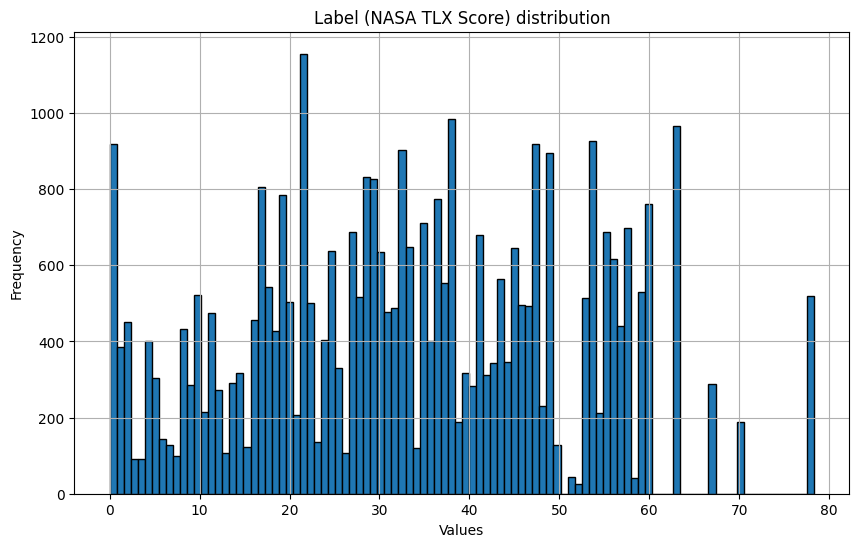

In [68]:
plot_histogram(series=features_.label, bins=100, title='Label (NASA TLX Score) distribution')

In [78]:
scatter_plot_feature(features_, feature='TEMPmax', num_points=features_.shape[0], title='BVPmax Scatter Plot', xlabel='Index', ylabel='BVPmax Value')

KeyError: 'TEMPmax'

<Figure size 1000x600 with 0 Axes>